# Nested Healpixel to Priors

In [1]:
# importing plotting and locus tools
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt
import MakePriors as mp

In [2]:
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import optimize
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from getpass import getpass
import pandas as pd
import healpy as hp
import numpy as np

In [3]:
#define what nested healpixel you want and for what nside 
#(called healpixel variable nested32 bc that is the ordering and resolution I have been using)
nested32 = 12287
nside = 32

In [4]:
#create array for nested nside=256 pixels within a given nested nside=32 pixel 
npixratio = hp.nside2npix(256)/hp.nside2npix(nside)
start = npixratio * nested32
stop = start + npixratio
nested256_array = np.arange(start, stop, 1, dtype=int)
nested256_array

array([786368, 786369, 786370, 786371, 786372, 786373, 786374, 786375,
       786376, 786377, 786378, 786379, 786380, 786381, 786382, 786383,
       786384, 786385, 786386, 786387, 786388, 786389, 786390, 786391,
       786392, 786393, 786394, 786395, 786396, 786397, 786398, 786399,
       786400, 786401, 786402, 786403, 786404, 786405, 786406, 786407,
       786408, 786409, 786410, 786411, 786412, 786413, 786414, 786415,
       786416, 786417, 786418, 786419, 786420, 786421, 786422, 786423,
       786424, 786425, 786426, 786427, 786428, 786429, 786430, 786431])

In [5]:
#convert array from nested to ring healpixel numbering
ring256_array = hp.nest2ring(256, nested256_array)
ring256_array

array([408960, 407936, 407935, 406912, 406913, 405889, 405888, 404865,
       406911, 405887, 405886, 404863, 404864, 403840, 403839, 402816,
       404866, 403842, 403841, 402818, 402819, 401795, 401794, 400771,
       402817, 401793, 401792, 400769, 400770, 399746, 399745, 398722,
       404862, 403838, 403837, 402814, 402815, 401791, 401790, 400767,
       402813, 401789, 401788, 400765, 400766, 399742, 399741, 398718,
       400768, 399744, 399743, 398720, 398721, 397697, 397696, 396673,
       398719, 397695, 397694, 396671, 396672, 395648, 395647, 394624])

In [6]:
#function to define query with list of healpixels and quantities to retrieve from lsst_sim.simdr2 table at Astro Lab
def makeQueryString(ring256_array):
    query1 = """
    SELECT ra, dec, gall, galb, gc, logage, mass, label, logg, m_h, av, mu0, umag, gmag, rmag, imag, zmag, ymag, nest4096, ring256
    FROM lsst_sim.simdr2
    WHERE"""
    query = query1 + f" ring256 = {ring256_array[0]}"
    for ring in ring256_array[1:]:
        query += f" OR ring256 = {ring}"
    return query + "\n"

querystring = makeQueryString(ring256_array)
print(querystring)


    SELECT ra, dec, gall, galb, gc, logage, mass, label, logg, m_h, av, mu0, umag, gmag, rmag, imag, zmag, ymag, nest4096, ring256
    FROM lsst_sim.simdr2
    WHERE ring256 = 408960 OR ring256 = 407936 OR ring256 = 407935 OR ring256 = 406912 OR ring256 = 406913 OR ring256 = 405889 OR ring256 = 405888 OR ring256 = 404865 OR ring256 = 406911 OR ring256 = 405887 OR ring256 = 405886 OR ring256 = 404863 OR ring256 = 404864 OR ring256 = 403840 OR ring256 = 403839 OR ring256 = 402816 OR ring256 = 404866 OR ring256 = 403842 OR ring256 = 403841 OR ring256 = 402818 OR ring256 = 402819 OR ring256 = 401795 OR ring256 = 401794 OR ring256 = 400771 OR ring256 = 402817 OR ring256 = 401793 OR ring256 = 401792 OR ring256 = 400769 OR ring256 = 400770 OR ring256 = 399746 OR ring256 = 399745 OR ring256 = 398722 OR ring256 = 404862 OR ring256 = 403838 OR ring256 = 403837 OR ring256 = 402814 OR ring256 = 402815 OR ring256 = 401791 OR ring256 = 401790 OR ring256 = 400767 OR ring256 = 402813 OR ring256 = 401

In [7]:
#retrieve patch using MakePriors.py 
nested_patch = mp.retrievePatch(querystring)

querying...
converting...
retrieved patch with 321779  entries


r= 13.5 to 14.5 N= 10296928 Ns= 18912


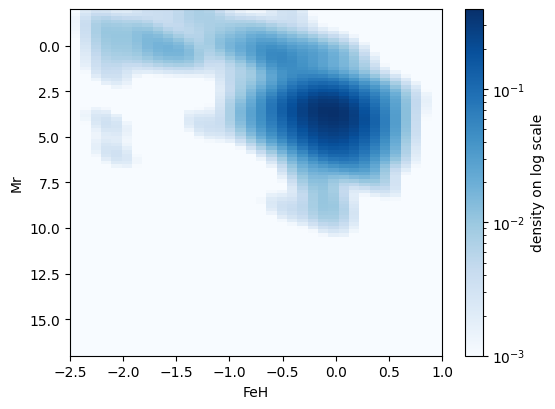

r= 14.0 to 15.0 N= 10296928 Ns= 24768


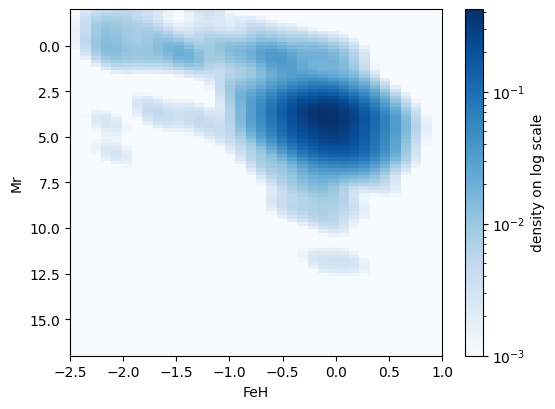

r= 14.5 to 15.5 N= 10296928 Ns= 34208


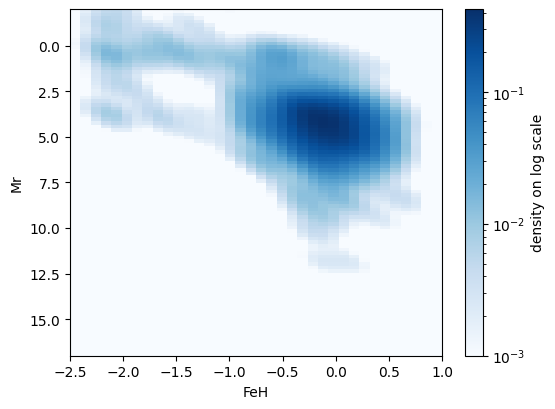

r= 15.0 to 16.0 N= 10296928 Ns= 44864


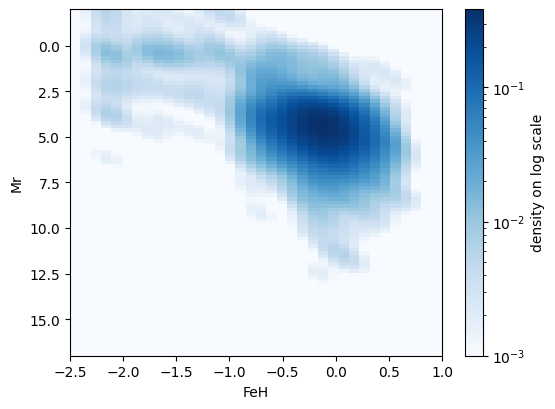

r= 15.5 to 16.5 N= 10296928 Ns= 58176


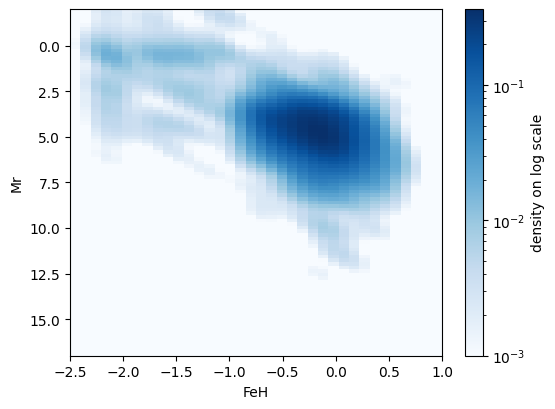

r= 16.0 to 17.0 N= 10296928 Ns= 74848


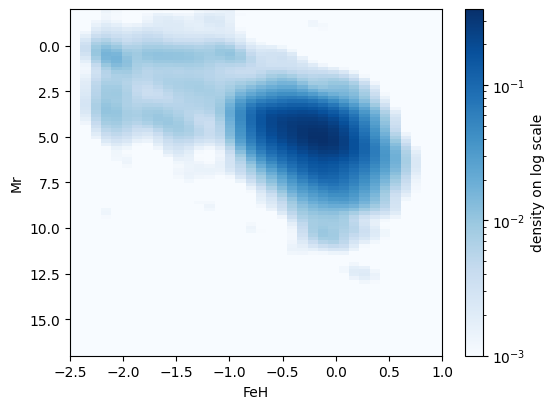

r= 16.5 to 17.5 N= 10296928 Ns= 90944


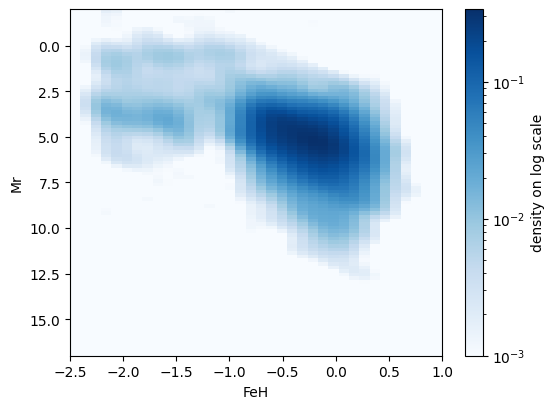

r= 17.0 to 18.0 N= 10296928 Ns= 112384


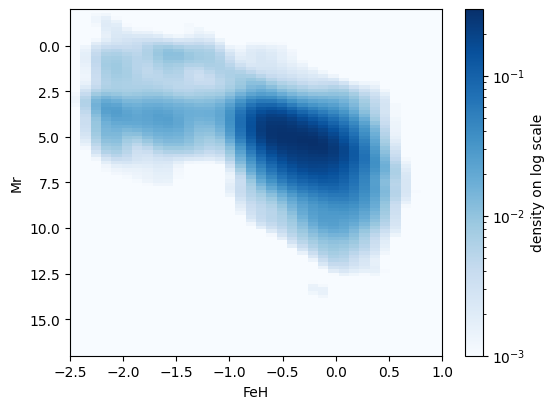

r= 17.5 to 18.5 N= 10296928 Ns= 140128


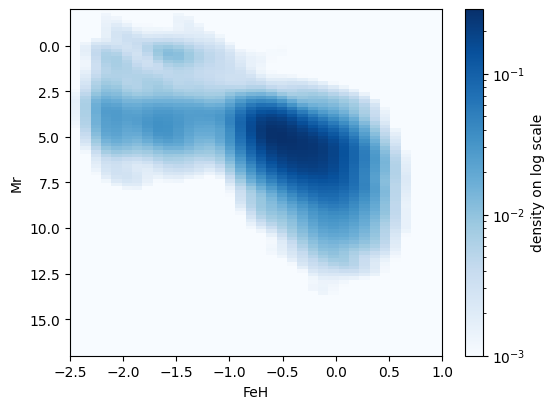

r= 18.0 to 19.0 N= 10296928 Ns= 167136


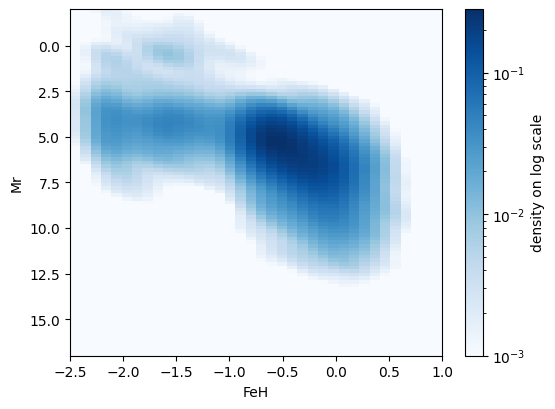

r= 18.5 to 19.5 N= 10296928 Ns= 202720


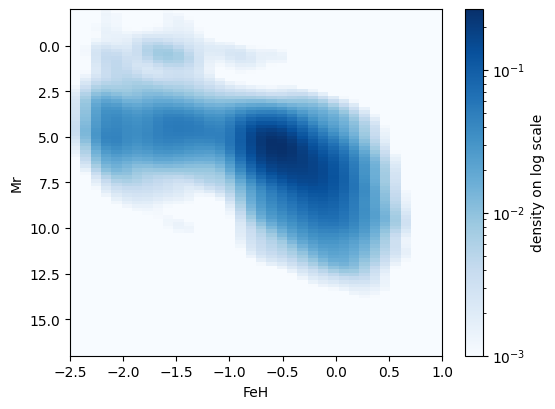

r= 19.0 to 20.0 N= 10296928 Ns= 255712


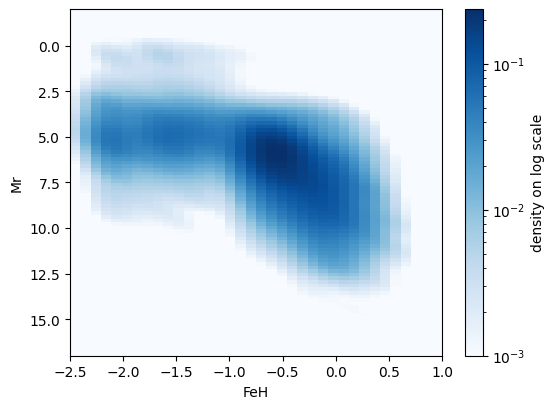

r= 19.5 to 20.5 N= 10296928 Ns= 315296


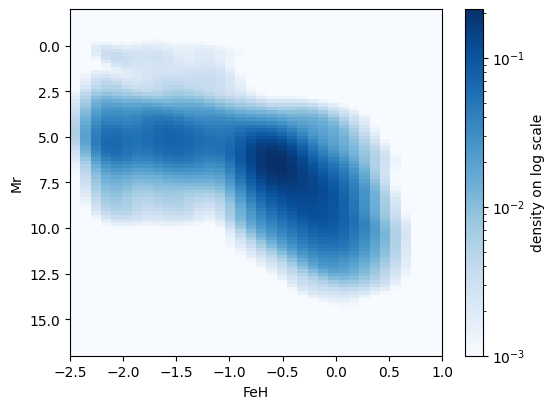

r= 20.0 to 21.0 N= 10296928 Ns= 374560


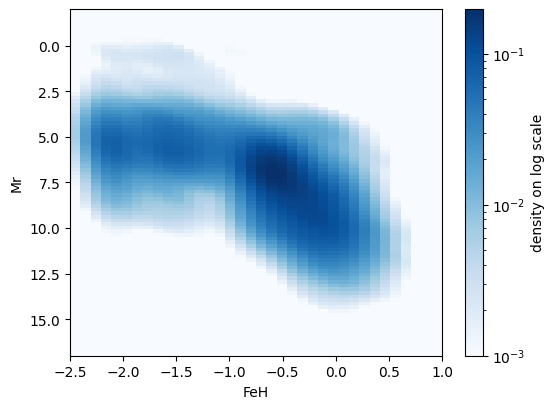

r= 20.5 to 21.5 N= 10296928 Ns= 446240


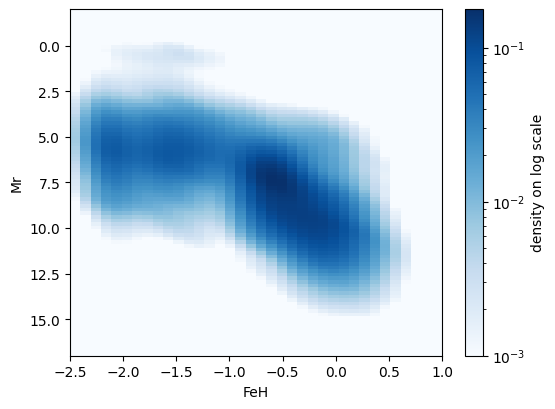

r= 21.0 to 22.0 N= 10296928 Ns= 541632


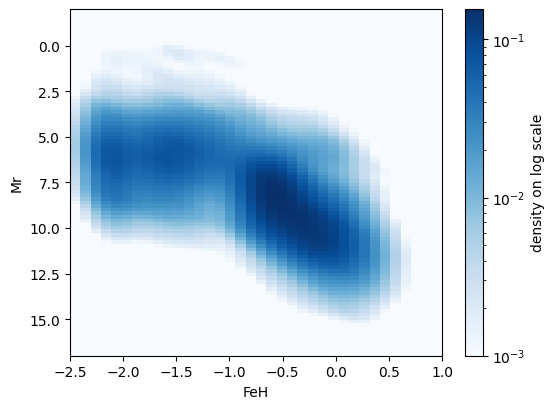

r= 21.5 to 22.5 N= 10296928 Ns= 658944


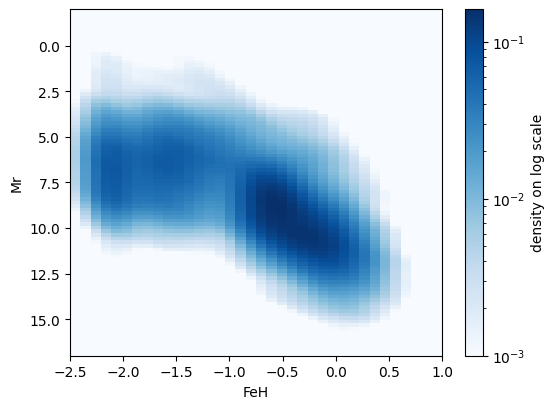

r= 22.0 to 23.0 N= 10296928 Ns= 807584


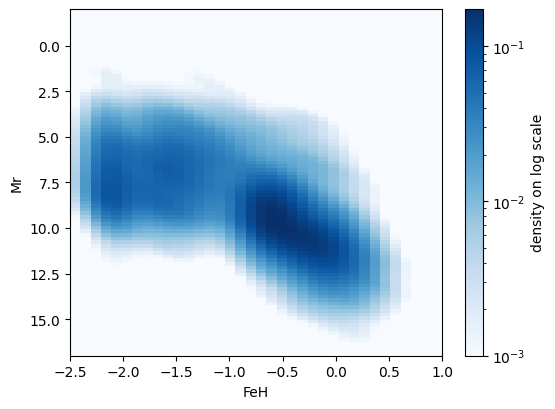

r= 22.5 to 23.5 N= 10296928 Ns= 988672


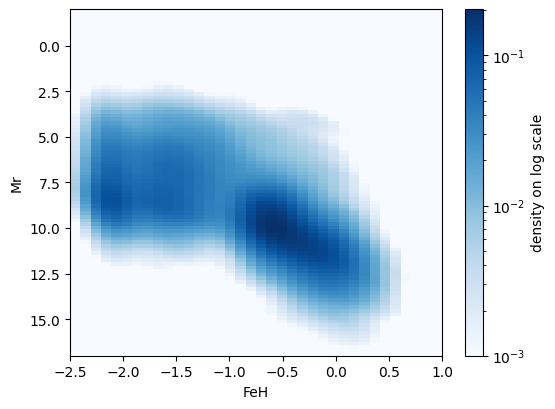

r= 23.0 to 24.0 N= 10296928 Ns= 1178848


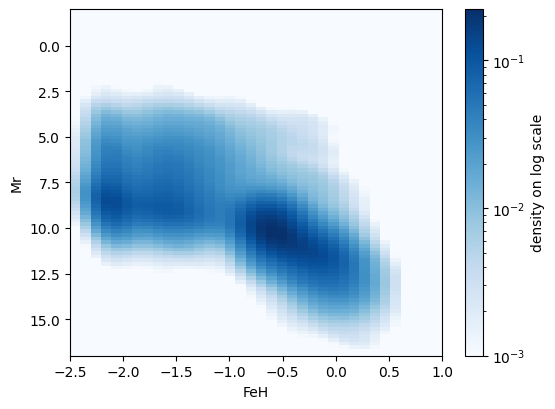

r= 23.5 to 24.5 N= 10296928 Ns= 1386880


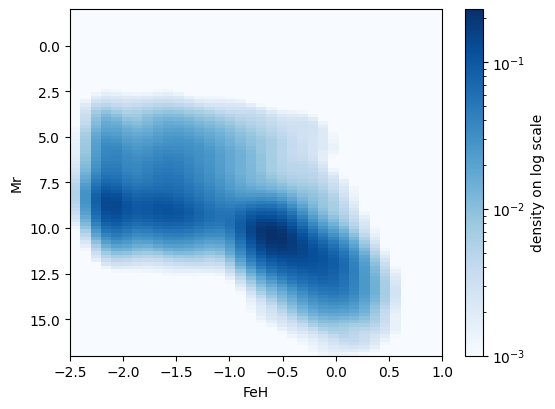

r= 24.0 to 25.0 N= 10296928 Ns= 1587008


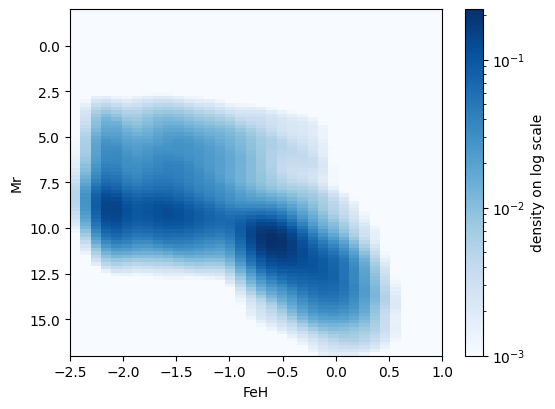

r= 24.5 to 25.5 N= 10296928 Ns= 1758592


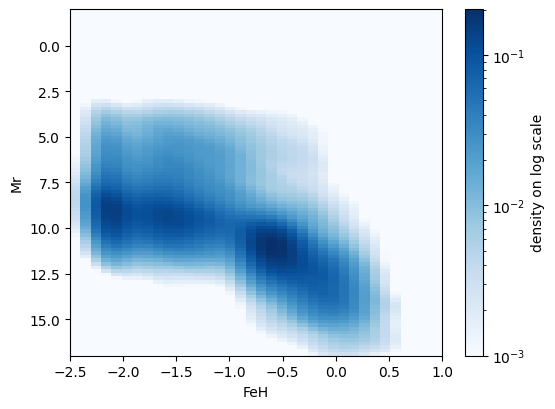

r= 25.0 to 26.0 N= 10296928 Ns= 1905792


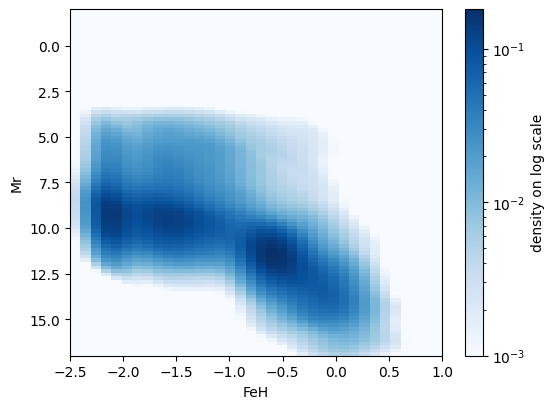

r= 25.5 to 26.5 N= 10296928 Ns= 2021056


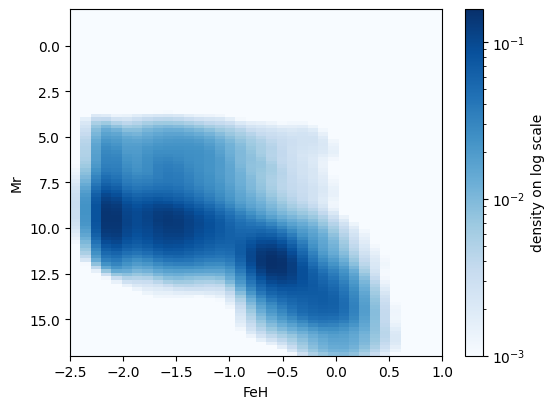

r= 26.0 to 27.0 N= 10296928 Ns= 2101248


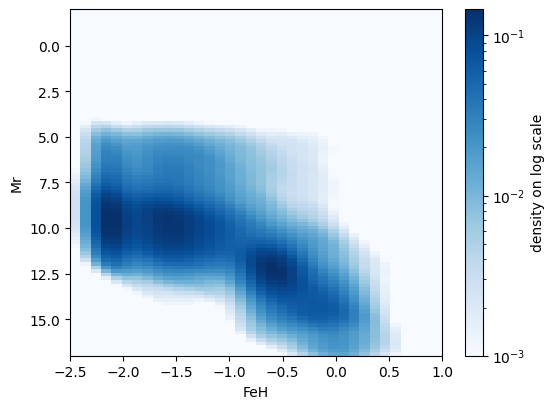

r= 26.5 to 27.5 N= 10296928 Ns= 2147808


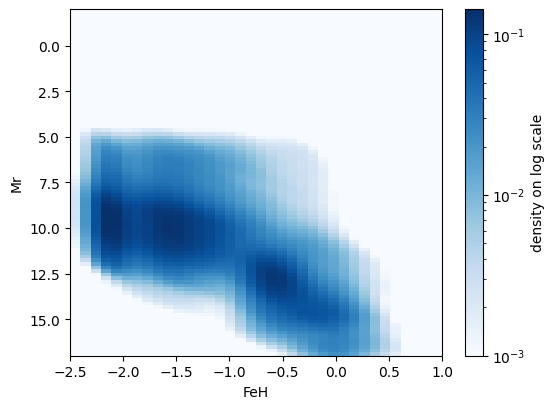

In [8]:
#dump prior maps, replace string with desired location for prior maps
rootname = 'priorsDir/nested12287'
bt.dumpPriorMaps(nested_patch, rootname)